# Legged Robots - Final Project

This project focuses on the development and evaluation of a motion planning and control system for legged robots, specifically addressing the challenges of generating stable and dynamic locomotion. The project leverages a combination of Model Predictive Control (MPC) and trajectory planning to achieve coordinated movements between the robot's base body and its individual legs. The framework has been implemented within the MuJoCo simulation environment, enabling robust evaluation and rapid prototyping of different locomotion strategies.

The codebase is organized into three primary components: **motion planning**, **control**, and **state estimation**. Each component is critical for achieving stable locomotion and is detailed as follows:

### Motion Planning

The planner is divided into two levels: a global planner responsible for the base-body motion, and a local planner that calculates foot trajectories and ground contact forces. The global planner computes continuous body motion based on desired linear and angular velocities, while the local planner, using MPC, predicts foot trajectories and contact forces for the immediate future. These planned motions serve as inputs for the control system.

### Control System

The control architecture consists of two controllers: one for legs in the stance phase and another for legs in the swing phase. The stance controller uses force estimates from the MPC, while the swing controller ensures that the leg follows its predefined trajectory. The outputs from both controllers are combined and applied as control inputs to the model.

### State 

Although state estimation is essential in real-world applications, the focus of this project is on the planning and control components. Therefore, the required state variables, such as joint positions and velocities, are extracted directly from the MuJoCo simulation. Advanced operations like calculating contact Jacobians are performed using MuJoCo's inbuilt capabilities.

In addition to these core components, the project incorporates several auxiliary modules, including inverse kinematics and dynamic linearization, to support various aspects of the robot’s motion.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from project_code.constants import *

%load_ext autoreload
%autoreload 2

## 1. Global Planning - Base Body Trajectory

The `BasePlanner` class is designed as a foundational global planner, facilitating easy extensibility for future developments. This class provides two key functions:

- `update(state, **kwargs)`: Updates the planner with the robot's current state. Although currently not functional, this method has been included for potential future expansion.
  
- `evaluate_trajectory(time)`: Computes the robot's position and velocity at a specified time, based on the desired motion parameters.

### Trajectory Computation

The current implementation supports two modes of trajectory generation:
- **Straight-line motion** when only a linear velocity command is provided, or
- **Circular motion** when both linear and angular velocity commands are specified.

To avoid discontinuities in the robot's motion, an acceleration is applied until the target velocity is reached. The linear velocity is constrained to the robot's forward direction in the local frame, and angular velocity is applied as a yaw rate.

### Kinematics on a Circular Arc

The position $s$ and velocity $\dot{s}$ along the arc are given by the following kinematic equations during the acceleration phase:

$$
s = \frac{1}{2}at^2
$$

$$
\dot{s} = at
$$

When the velocity $\dot{s}$ reaches the desired velocity $v_d$ at the time $t_{acc}$, the acceleration is set to zero, and the robot continues to move at a constant velocity:

$$
s = \frac{1}{2}at_{acc}^2 + v_d (t - t_{acc})
$$

$$
\dot{s} = v_d
$$

### Straight-Line Trajectory (Zero Angular Velocity)

In the case where the desired angular velocity is zero ($\omega_d = 0$), the trajectory simplifies to linear motion:

$$
x = s, \quad y = 0, \quad \psi = 0
$$

The corresponding velocities are:

$$
\dot{x} = \dot{s}, \quad \dot{y} = 0, \quad \dot{\psi} = 0
$$

### Circular Trajectory (Non-Zero Angular Velocity)

For non-zero angular velocity, the robot follows a circular trajectory with radius $r$, derived from the desired linear velocity $v_d$ and angular velocity $\omega_d$:

$$
r = \frac{v_d}{\omega_d}
$$

The position and velocity in circular motion can be described as:

$$
x = r \sin(\psi), \quad y = r \left( 1 - \cos(\psi) \right), \quad \psi = \frac{s}{r}
$$

The corresponding velocities are:

$$
\dot{x} = \dot{s} \cos(\psi), \quad \dot{y} = \dot{s} \sin(\psi), \quad \dot{\psi} = \frac{\dot{s}}{r}
$$

### Planner Output

The `BasePlanner` outputs the robot's position and velocity based on the above kinematic equations. Depending on the presence of angular velocity, the planner accommodates both straight-line and circular trajectories, ensuring a smooth transition between different motion phases.


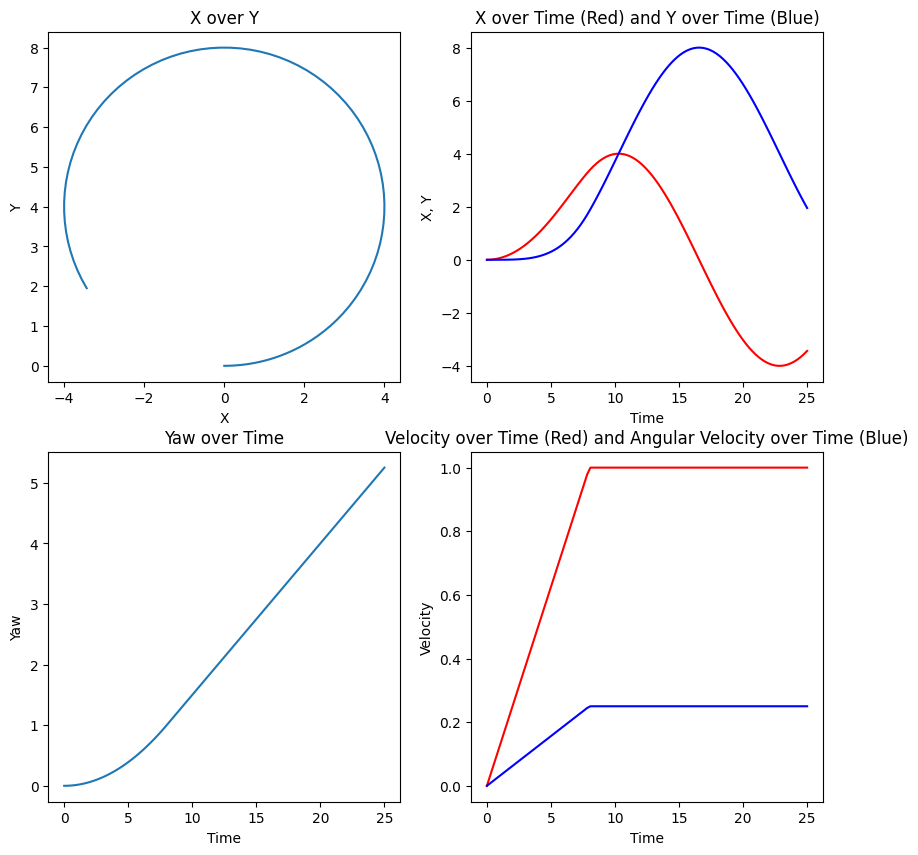

In [2]:
from project_code.planner import BasePlanner
from project_code.utils import plot_trajectory

base_planner = BasePlanner(des_linear_velocity=1.0, # Edit these values to see how the trajectory changes
                           des_angular_velocity=0.25,
                           des_acceleration=0.125)

time_steps = np.linspace(0, 25, 100)
trajectory_position = []
trajectory_velocity = []

for t in time_steps:
    o_X_b, o_V_b = base_planner.evaluate_trajectory(t)
    trajectory_position.append(o_X_b)
    trajectory_velocity.append(o_V_b)
    
trajectory_position = np.stack(trajectory_position)
trajectory_velocity = np.stack(trajectory_velocity)

plot_trajectory(trajectory_position, trajectory_velocity, time_steps)

## 2. Local Planning - Feet Trajectory

The <code>FootPlanner</code> was the main focus of the project, and was therefor given the most attention. As can be derived from the `update(state, **kwargs)` function, there are four main steps involved:

## 2. Local Planning - Feet Trajectory

The `FootPlanner` class was the primary focus of this project, and significant attention was devoted to its development. The planner operates through four main stages, as seen in the `update(state, **kwargs)` function:

- Step 1: Update the Swing Progress 
- Step 2: Update of Stance Leg Position
- Step 3: Update of Swinging Feet Trajectories
- Step 4: Calculation of Ground Contact Forces

### Step 1 - Update Swing Progress
The planner utilizes a fixed, preplanned gait pattern, parametrized by nine variables:
- For each foot, two parameters ($t_a$ and $t_b$) define the start and end of the stance phase. This approach allows for the easy representation of various natural gait patterns, such as gallop and canter. In the following examples, a crawling gait will be primarily used. Additionally, a trotting gait has also been implemented.
- An additional parameter defines the period over which the entire gait cycle is repeated.

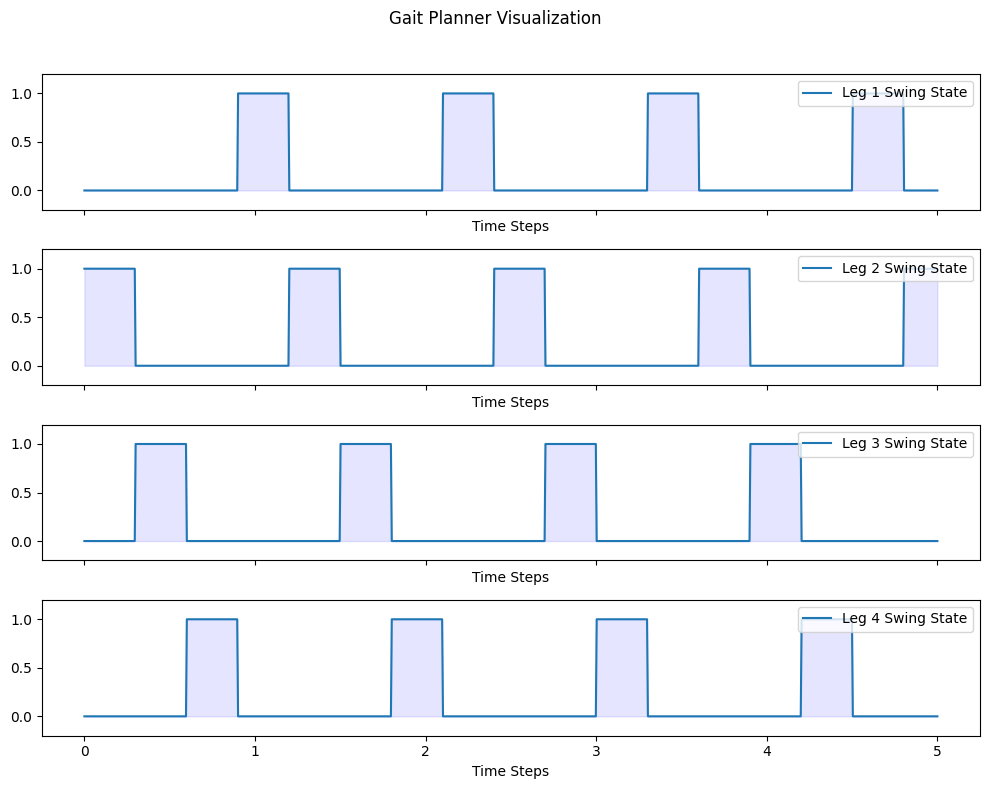

In [3]:
from project_code.planner import FootPlanner
from project_code.utils import plot_t_ab

time_steps = np.linspace(0, 5, 1000)
period = 1.2
t_ab, t_st, t_sw = FootPlanner._create_t_ab(gait = CRAWL,
                                            period = period)

plot_t_ab(t_ab, period, time_steps)

In the gait pattern plot above, a value of zero corresponds to stance, while non-zero values indicate the swing phase. One issue identified in the current implementation is that for one leg, the planner initiates the robot in a swing phase, which will need to be corrected.

Based on these parameters, we transform the current time into the swing time domain, where the time is set to zero at the moment the foot lifts off the ground and to one when it touches down again. Post-touchdown, the value wraps around to a negative number, signaling the stance phase. 

An exception occurs during the first gait cycle, where we enforce constant values for all legs to prevent premature lifting upon initialization.

The swing progress calculation begins by subtracting the touchdown time from the current time:

$$
\tilde{t} = t - t_a
$$

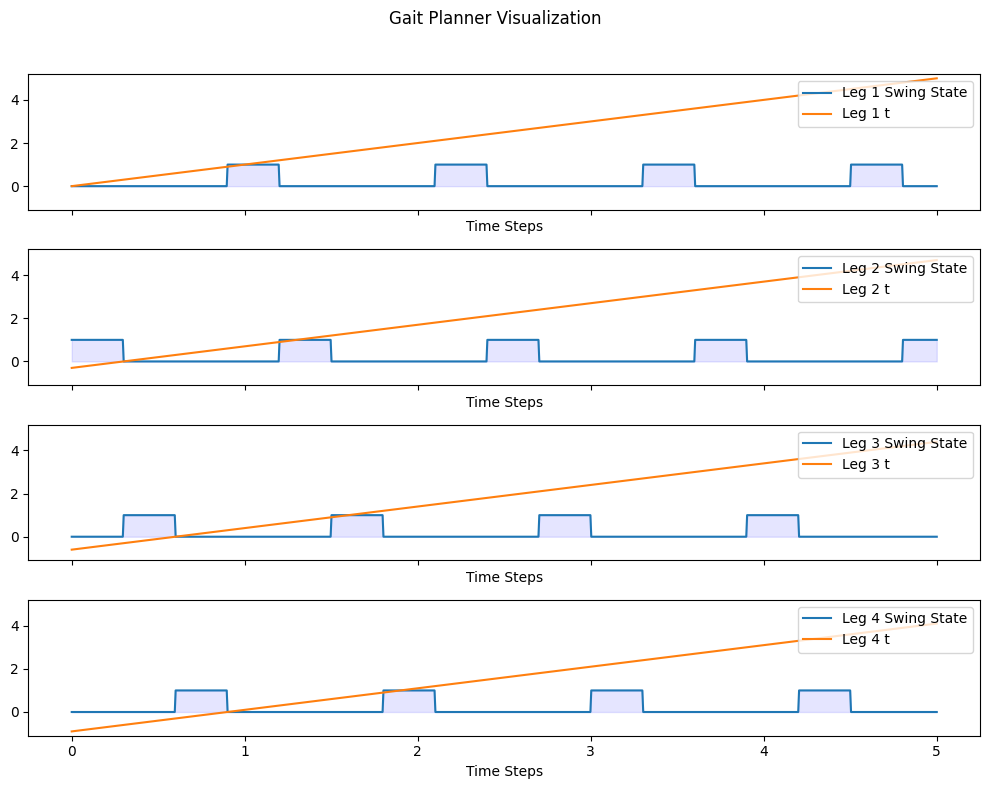

In [4]:
from project_code.utils import plot_t

t_dash = time_steps[:, None] - t_ab[:, 0][None, :] # Do this for all legs in one step using broadcasting

plot_t(t_dash, t_ab, period, time_steps)

This step eliminates phase offsets, such that $\tilde{t}$ represents the elapsed time since the first stance phase. For legs initially in swing, $\tilde{t}$ will be negative. Using modulo division with the period $T$, time wraps after one cycle, and `np.fmod(x)` is used to ensure negative values can be retained:

$$
\mathring{t} = fmod(\tilde{t}, T)
$$

The function then clips negative values to zero, ensuring a stance phase for legs that should remain grounded initially:

$$
\mathring{t}_c = clip(\mathring{t}, \: min=0, \: max=T)
$$

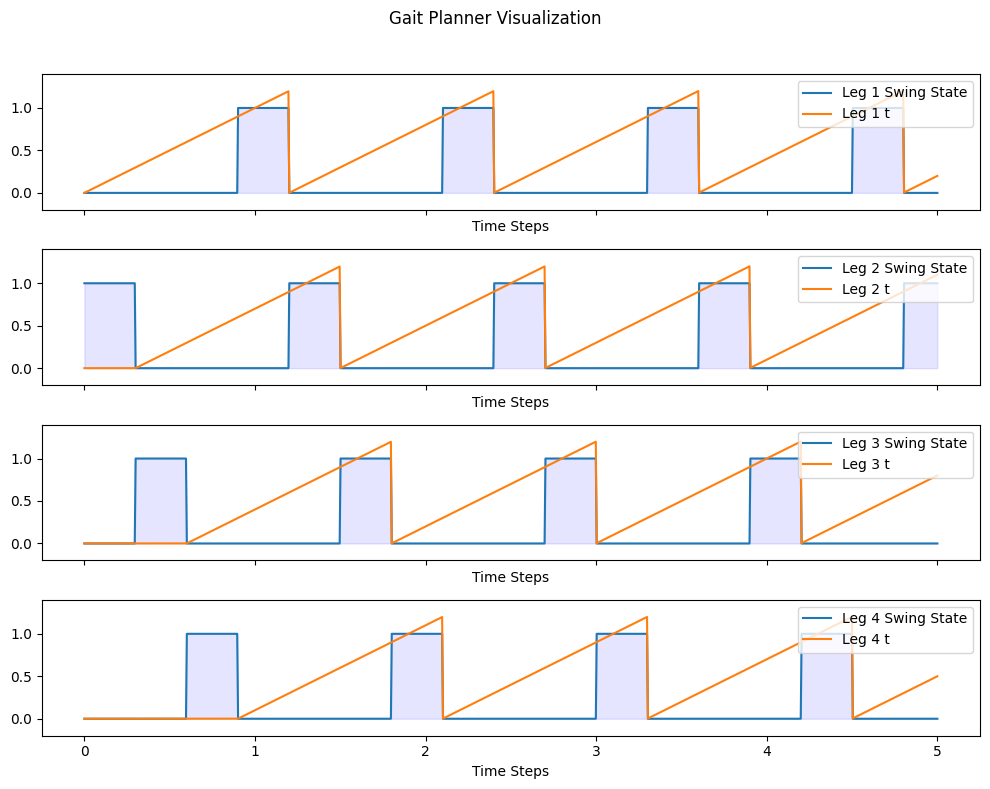

In [5]:
t_circ = np.fmod(t_dash, period)
t_circ = np.clip(t_circ, 0, period)

plot_t(t_circ, t_ab, period, time_steps)

Finally, we map the swing progress from zero (start of swing phase) to one (end of swing phase) by applying a scale and shift transformation:

$$
\tilde{t}_{sw} = \frac{1}{t_{sw}} \cdot (\mathring{t}_c - t_{st})
$$

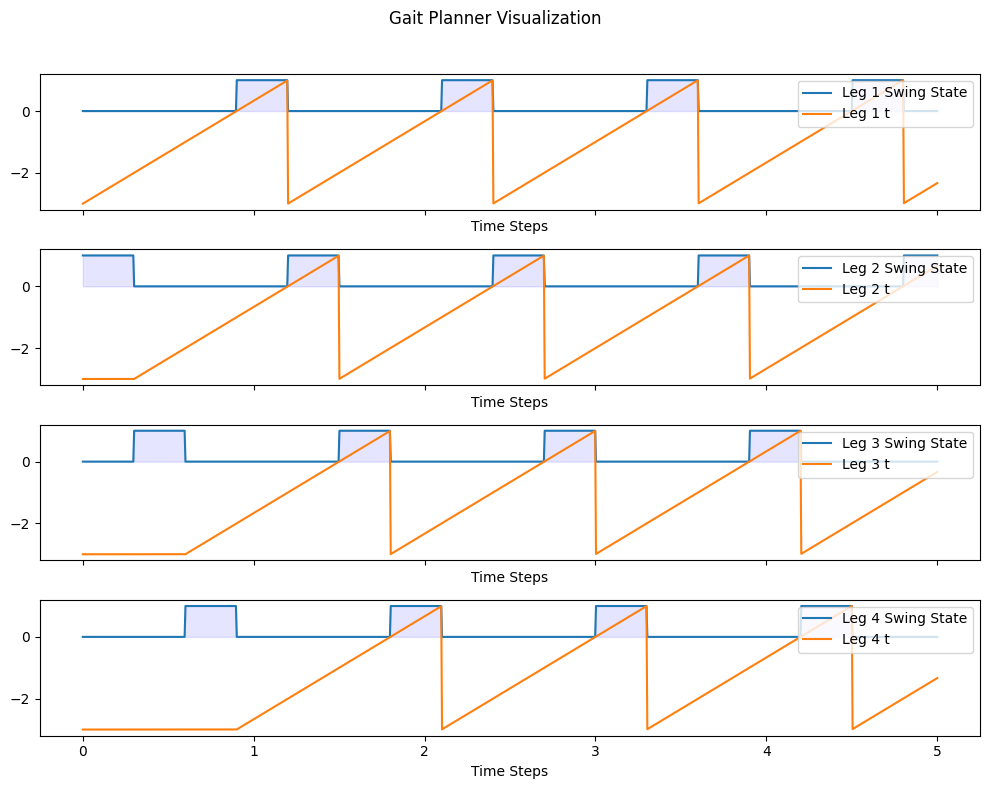

In [6]:
sw_prog = 1 / (t_sw[None, :]) * (t_circ- t_st[None, :])

plot_t(sw_prog, t_ab, period, time_steps)

### Step 2 - Update of Stance Leg Position

In this step, the positions of all feet in stance are stored. The current implementation assumes that any foot designated to be in stance remains in contact with the ground, updating its position accordingly. A more robust approach might involve detecting ground contact to determine foot positions. These positions, denoted as ${}_\mathcal{O}p_{f}(t_{to})$, where $t_{to}$ is the foot's take-off time, will later be used to calculate the trajectory of swinging legs.

### Step 3 - Update of Swinging Feet Trajectories

#### Step 3.1 - Calculation of Symmetrical Point

To compute the trajectories of swinging feet, the position of the robot's hip (or shoulder) projected onto the ground at touchdown is estimated. This position is commonly referred to as the symmetrical point, as the foot reaches its maximum height at this location. The base body's position ${}_\mathcal{O}p_b$ and yaw angle ${}_\mathcal{O}\psi_b$ at touchdown $t_{td}$ are estimated using the current linear and angular velocities:

$${}_\mathcal{O}p_b(t_{td}) \approx {}_\mathcal{O}p_b(t) + {}_\mathcal{O}v_b(t) \cdot (1 - \tilde{t}_{sw})t_{sw}$$

$${}_\mathcal{O}\psi_b(t_{td}) \approx {}_\mathcal{O}\psi_b(t) + {}_\mathcal{O}\omega_{b,z}(t) \cdot (1 - \tilde{t}_{sw})t_{sw}$$

where $\tilde{t}_{sw}$ is the swing progress, and $t_{sw}$ is the duration of the swing phase. Although this information could be derived from the global planner, decoupling the foot trajectories from the desired body position allows the system to react to body dynamics.

Using the estimated base position and orientation at touchdown, the hip position is calculated as:

$$
{}_\mathcal{O}p_{hip}(t_{td}) =  {}_\mathcal{O}p_b(t_{td}) + R_z\left({}_\mathcal{O}\psi_b(t_{td})\right){}_bp_{hip}
$$

#### Step 3.2 - Calculation of End Position of Swing Phase

Given the stance phase duration and the base velocity, the distance covered by the base during this phase is computed. Following the Spring-Loaded Inverted Pendulum (SLIP) model, the foot is positioned to be at the midpoint of this motion:

$$ \Delta p_1 = {}_\mathcal{O}v_b \cdot \frac{t_{st}}{2} $$

Angular velocity also affects the hip's lateral movement, accounted for by:

$$ \Delta p_2 = R_z\left({}_\mathcal{O}\psi_b(t_{td})\right)\left[R_z\left({}_\mathcal{O}\omega_{b,z} \cdot \frac{t_{st}}{2}\right)- I\right] {}_bp_{hip} $$

Additionally, velocity deviations are corrected to stabilize foot placement:

$$ \Delta p_3 = k_p({}_\mathcal{O}v_b - {}_\mathcal{O}v_{b,d}) $$

where ${}_\mathcal{O}v_{b,d}$ is the desired base velocity.

Finally, centrifugal forces are considered, modeling the quadruped as an inverted pendulum:

$$ \Delta p_4 = \frac{{}_\mathcal{O}p_{b,z}}{-g}{}_\mathcal{O}v_b \times {}_\mathcal{O}\omega_{b} $$

The final foot position at touchdown is then given by:

$$ {}_\mathcal{O}p_{f}(t_{td}) = {}_\mathcal{O}p_{hip}(t_{td}) + \Delta p_1 + \Delta p_2 + \Delta p_3 + \Delta p_4 $$

#### Step 3.3 - Calculation of Polynomial Coefficients

The foot trajectories are parametrized using cubic polynomials, which minimize the foot's acceleration. The boundary conditions are:

$$ p(0) = {}_\mathcal{O}p_{f}(t_{to}), \quad p(1) = {}_\mathcal{O}p_{f}(t_{td})$$
$$ v(0) = 0, \quad v(1) = 0$$

These conditions define the x and y polynomials, while the z trajectory is split into two parts, reaching a peak at $\tilde{t}_{sw} = 0.5$. The resulting curves are visualized in the accompanying graph.

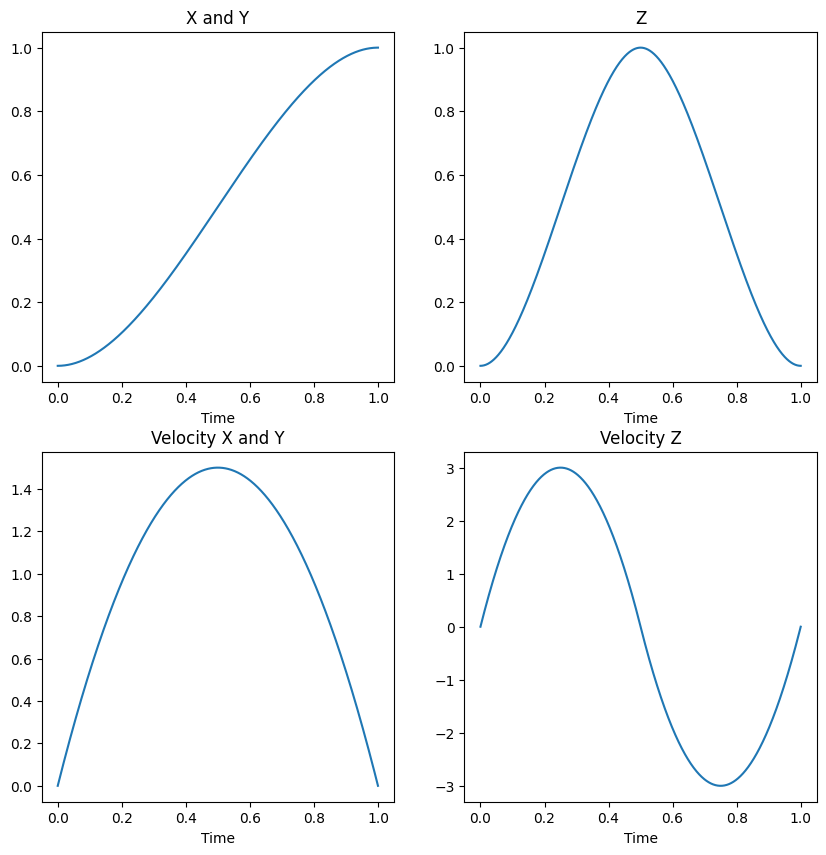

In [7]:
from project_code.utils import plot_polynomials

plot_polynomials()

#### Step 3.4 - Calculation of Ground Contact Forces

For legs in stance, the Model Predictive Controller (MPC) estimates the ground reaction forces necessary to achieve the base motion specified by the global planner. This process is further elaborated in the MPC section.

### Simulation and Verification using Inverse Kinematics

To validate the performance of the planner, we integrate its outputs into a simulation of the robot's motion. The simulation calculates the joint positions required to achieve the desired base body pose and foot positions using an Inverse Kinematics (IK) algorithm. 

By providing the planned trajectories for the base and feet, the IK solver computes the corresponding joint angles for all four legs, ensuring that the robot adheres to the desired motion. This approach allows for a comprehensive evaluation of the planner, ensuring that the generated trajectories are feasible and the robot can physically achieve the commanded poses.

In [8]:
import mujoco
import mujoco.viewer
import mediapy as media
from project_code.state import State
from project_code.constants import *
from project_code.utils import IKNewton 
from project_code.planner import Planner

file_name = "model/scene.xml" 
model = mujoco.MjModel.from_xml_path(file_name)
data = mujoco.MjData(model)

renderer = mujoco.Renderer(model)

mujoco.mj_resetDataKeyframe(model, data, 0)
mujoco.mj_forward(model, data)
state = State(model, data)

In [9]:
planner = Planner(CRAWL, 0.7, 0.25, 0.25, 0.25)
planner = Planner(WALKING_TROT, 0.5, 0.5, 0.5, 0.25)

In [11]:
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 2
camera.azimuth = 110

frames = []

mujoco.mj_resetDataKeyframe(model, data, 0)
mujoco.mj_forward(model, data)
  
for i in range(1000):
    planner.update_planner(state=state, mode=NO_FORCE)
    X_d, vel, acc = planner.evaluate_trajectory(state.time())
    q_d = IKNewton(X_d, state.get_qpos_euler())
    state.set_qpos_euler(q_d)
    
    mujoco.mj_forward(model, data)
    
    camera.lookat = data.body('base').subtree_com
    renderer.update_scene(data, camera)
    pixels = renderer.render()
    frames.append(pixels)
    state.update_time(params['t_sim'] * 1)
    
media.show_video(frames, fps= 1 / (params['t_sim'] * 1))

# 3. Model Predictive Control
In order to control the trajectroy of the robot by applying contact forces through the legs during the stance phase several factors have to be considered:

1. The relationship between the control inputs (forces applied) and the rate of variation in the robot states, which is reflected through a dynamic model of the system
2. The tracking of a desired refrence signal, not only for the current timestep, but also for future timesteps.
3. The constraints with respect to control inputs. For instance, for optimal traction and maintaining planner assumptions, slipping should be avoided by bounding the tangential components of the contact forces based on the magnitude of the normal components.

To satisfy these requirements, **Model Predictive Control (MPC)** was implemented to realize finite horizon discrete time optimal control. The notable features of MPC are its ability to optimize control inputs over a prediction horizon based on a desired reference state trajectory and given dynamic model of the system, satisfying requirements 1 and 2. Essentially, the predictive and flexible nature of MPC enables more complex control scenarios compared to purely reactive controllers such as PID. Moreover, requirement 3 can be satisfied by formulating explicit constraints on the control inputs.

This section contains details of an MPC implementation using a quadratic program solver and usage examples of the resulting python class.


## 3.1 Single Rigid Body Dynamics

The Model Predictive Control (MPC) implementation relies on a linearized, discrete-time dynamic model of the quadruped. Assuming that the robot’s mass is concentrated at the center of mass (CoM) and that the only external forces are the contact forces, the dynamics can be described using Newton and Euler laws:

$$
x_{k+1} = A_k x_k + B_k u_k
$$

where $ A_k $ and $ B_k $ are the state transition and input matrices at the $k$-th time step, and $ x_k $ and $ u_k $ represent the state and control input, respectively. By assuming that the roll and pitch rotations are negligible, we can derive the following formulation:

$$
A_k = \begin{bmatrix}
\mathbb{I}_3 & 0_{3\times3} & \mathbb{I}_3\Delta T & 0_{3\times3} & 0_{3\times1} \\
0_{3\times3} & \mathbb{I}_3 & 0_{3\times3} & R_z^T(\psi)\cdot\Delta T & 0_{3\times1} \\
0_{3\times3} & 0_{3\times3} & \mathbb{I}_3 & 0_{3\times3} & e_z \cdot \Delta T \\
0_{3\times3} & 0_{3\times3} & 0_{3\times3} & \mathbb{I}_3 & 0_{3\times1} \\
0_{1\times3} & 0_{1\times3} & 0_{1\times3} & 0_{1\times3} & 1
\end{bmatrix},
$$

where the state vector $ x_k $ is defined as:

$$
x_k = \begin{bmatrix}
{}_\mathcal{O}p_{b} \\
{}_\mathcal{O}\Theta_{b} \\
{}_\mathcal{O}v_{b} \\
{}_\mathcal{O}\omega_{b} \\
-g 
\end{bmatrix},
$$

and the input matrix $ B_k $ is:

$$
B_k = \begin{bmatrix}
0_{3\times3} & 0_{3\times3} & 0_{3\times3} & 0_{3\times3} \\
0_{3\times3} & 0_{3\times3} & 0_{3\times3} & 0_{3\times3} \\
\mathbb{I}_3 \Delta T / m & \mathbb{I}_3 \Delta T / m & \mathbb{I}_3 \Delta T / m & \mathbb{I}_3 \Delta T / m \\
\Delta T \left({}^{b}_\mathcal{O}I\right)^{-1} r_{1\times} & \Delta T \left({}_\mathcal{O}^{b}I\right)^{-1} r_{2\times} & \Delta T \left({}_\mathcal{O}^{b}I\right)^{-1} r_{3\times} & \Delta T \left({}_\mathcal{O}^{b}I\right)^{-1} r_{4\times} \\
0_{1\times3} & 0_{1\times3} & 0_{1\times3} & 0_{1\times3}
\end{bmatrix},
$$

where:

- $ \Delta T $ is the time step, 
- $ R_z(\psi) $ is the rotation matrix about the z-axis by angle $ \psi $,
- $ {}_\mathcal{O}p_{b} $ and $ {}_\mathcal{O}\Theta_{b} $ represent the current position and orientation (roll-pitch-yaw) of the base body’s CoM,
- $ {}_\mathcal{O}v_{b} $ and $ {}_\mathcal{O}\omega_{b} $ represent the velocity of the base body,
- $ m $ is the quadruped’s total mass,
- $ {}_\mathcal{O}^{b}I $ is the inertia matrix about the CoM in the world frame,
- $ r_{i\times} $ is the skew-symmetric matrix for the cross product with the relative position vector between each foot and the CoM,
- $ g $ is the gravitational acceleration.

The gravity constant $ g $ is incorporated directly into the state vector to remove bias terms from the dynamics. The contact state of the feet is not explicitly included in this model but is accounted for later through the MPC constraints.



## 3.2. MPC Problem Definition
The MPC problem can be stated as the following optimization problem over the control inputs $u_k$ and future predicted states $x_k$:
$$
\begin{align*}
J_k^*(x_k) = \min_{\{u_{k+i|k}\}_{i=0}^{N-1}} \quad & (x_{k+N|k} - x_{d_{k+N}})^T Q_N (x_{k+N|k} - x_{d_{k+N}})
+ \sum_{i=0}^{N-1} \left( (x_{k+i|k} - x_{d_{k+i}})^T Q (x_{k+i|k} - x_{d_{k+i}}) + u_{k+i|k}^T R u_{k+i|k} \right) \\
\text{subject to:} \quad & x_{k+i+1|k} = A_{k+i|k} x_{k+i|k} + B u_{k+i|k}, \quad \forall i \in \{0, \dots, N-1\} \\
& x_{k+i|k} \in \mathcal{X}, \quad u_{k+i|k} \in \mathcal{U}, \quad \forall i \in \{0, \dots, N-1\} \\
& x_{k+N|k} \in \mathcal{X}_f, \\
& x_{k|k} = x_k,
\end{align*}
$$
With:
- **$J$**: The cost function to be minimized
- **$N$**: Length of the prediction horizon
- **$x_{k+i|k}$**: The state vector at time step \(k+i\) given the initial state at time step \(k\)
- **$x_{d_{k+i}}$**: The desired or reference state at time step \(k+i\)
- **$u_{k+i|k}$**: The control input at time step \(k+i\) given the initial state at time step \(k\)
- **$Q$**: Weight matrix for the state tracking error
- **$R$**: Weight matrix for the control effort
- **$Q_N$**: Terminal weight matrix for the state at the final time step \(N\)
- **$x_{k+i+1|k} = A_{k+i|k} x_{k+i|k} + B u_{k+i|k}$**: Linearized discrete system dynamics at time step \(k+i\)
- **$\mathcal{X}$**: The feasible set of states
- **$\mathcal{U}$**: The feasible set of control inputs
- **$x_k$**: The initial state given to the controller


For ease of notation $A_{k+i|k}$ will be expressed by $A_{i+1}$ in the following. This optimization problem needs to be reevaluated at each MPC evaluation interval. (not necessarily each time step) The result is predicted optimal control input and state trajectories. The feasable sets pertaining to state and input costraints will be covered in more depth for a quadruped in a dedicated section.



## 3.3. Quadratic Programming Formulation
Quadratic programming (QP) refers to a well established class of constrained optimization with many existing efficient solvers in software. Due to the prevelance and generality of such solvers, MPC problems are often reformulated to fit a general quadratic program. In our case, the [OSQP](https://osqp.org/docs/index.html) solver is used due to its efficiency. (for a performance benchmark of existing solvers refer to [1])

A quadratic program is defined as the following optimization problem: (OSQP notation)
$$
\begin{align*}
\min_{x} \quad & \frac{1}{2} x^TPx + q^Tx\\
\text{subject to:} \quad & l\leq Ax \leq u \\
\end{align*}
$$

Where $x$ is the optimization variable. A, l, and u represent the constraint matrix, lower bound and upper bound respectively.

In order to solve the MPC problem as a QP, we need to construct the $P$ and $q$ matrices based on available MPC parameters, so that the optimization variable $x$ is equal to the compact control input vector $U = [u_{k|k}^T, u_{k+1|k}^T, \dots, u_{k+N-1|k}^T]^T$. In order to achieve this, a relation between the compact state vector $X = [x_{k|k}^T, x_{k+1|k}^T, \dots, x_{k+N|k}^T]^T$ and $U$ has to be deduced, yielding:

$$\mathbf{X} = \mathbf{M} \mathbf{x}_k + \mathbf{C} \mathbf{U}$$
where:
$$
M = \begin{bmatrix}
A_1 \\
A_1 \cdot A_2 \\
\vdots \\
\prod_{i=1}^{N} A_i
\end{bmatrix}
, \quad
C = \begin{bmatrix}
B & 0 & 0 & \dots & 0 \\
A_1 \cdot B & B & 0 & \dots & 0 \\
A_1 \cdot A_2 \cdot B & A_1 \cdot B & B & \dots & 0 \\
\vdots & \vdots & \vdots &\ddots & \vdots \\
\prod_{i=1}^{N-1} A_i \cdot B & \prod_{i=1}^{N-2} A_i & \prod_{i=1}^{N-3} A_i \cdot B & \dots & B
\end{bmatrix}
$$
are compact prediction matrices. Based on the above equation, The cost function can be rewritten as:
$$ J = (X - X_d)^T \bar{Q} (X - X_d) + U^T \bar{R} U$$
where:
$$
\bar{Q} = \begin{bmatrix}
Q & 0 & \dots & 0 \\
0 & Q & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & Q_N
\end{bmatrix}
, \quad
\bar{R} = \begin{bmatrix}
R & 0 & \dots & 0 \\
0 & R & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & R
\end{bmatrix}
$$
Finally, by using the compact prediction equation, P and q can be written as:
$$
P = 2 \left( C^T \bar{Q} C + \bar{R} \right)
, \quad
q = 2 \left((M x_k - X_d)^T \bar{Q} C \right)^T
$$



## 3.4. Constraint Formulation for a Quadruped
The dynamics constraints are implicitely enforced through the above compact prediction equations. In our case, the control inputs are the 3D contact forces applied by each leg. Given a friction constant $\mu$ between the feet and the floor, $\sqrt{F_x^2 + F_y^2} \leq \mu F_z$ formalizes the static friction requirements, while $0 \leq F_z \leq F_{max}$ prevents the robot from lifting a foot or exerting too much force that may end the stance phase prematurely. Since the square root is non-linear, the friction and normal force constraints can be approximated for one leg as:
$$
A_{leg} = \begin{bmatrix}
-1 &0 &\mu \\
0 &-1 &\mu \\
1 &0 &\mu \\
0 &1 &\mu \\
0 &0 &1
\end{bmatrix}
, \quad 
l_{leg} = \begin{bmatrix}
0 \\
\vdots \\
0 \\
\end{bmatrix}
, \quad
u_{leg} = \begin{bmatrix}
\infty \\
\infty \\
\infty \\
\infty \\
F_{max}
\end{bmatrix}
$$
Moreover, additional input constraints are in place for legs that are currently in the swing, phase by forcing the forces to be zero. (constraint matrix and uper and lower bounds set to identity and zero, respectively). This effectively decouples the stance and swing controllers. By concatonating these constraints for all legs, the final constraint matrix $A$ and bounds $l$ and $u$ can be constructed. The final constrained QP problem can be solved using the OSQP solver.

## 3.5. Implementation
A generalized python MPC solver class using the OSQP solver is implemented in `project_code/planner/mpc.py`. The class `MPC` is initialized and its features are demonstrated in the following examples:

In [12]:
from project_code.planner.mpc import MPC
import numpy as np

# simple decoupled decaying system (system will asymptotically approach the origin)
nx = 2
nu = 2
N = 20
Ak = np.array([[0.8, 0.0], [0.0, 0.5]])
Bk = np.eye(nx)

# define stage cost matrices (for each time step)
Q = 10*np.eye(nx)
R = np.eye(nu)

# initial and desired state
xk = np.zeros(nx)
Xd = np.ones((N, nx))

Unconstrained MPC example

Predicted cost: 7.316337572926297
Runtime: 2.00 ms


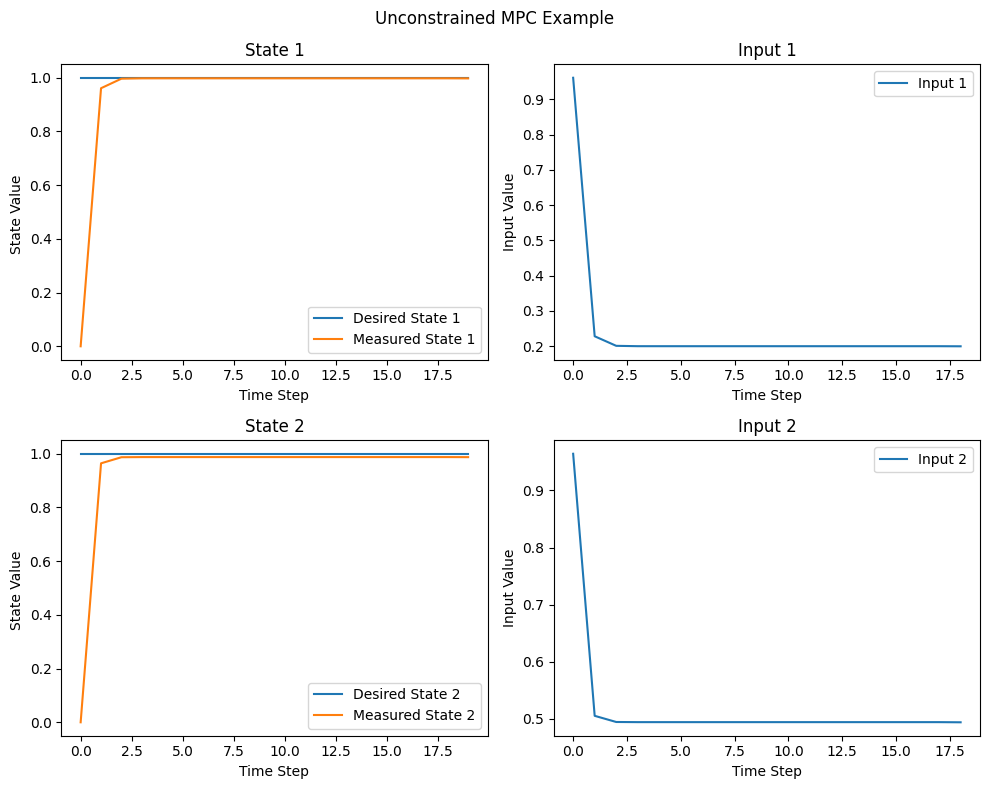

In [13]:
from project_code.utils import plot_mpc

# initialize unconstrained MPC
mpc1 = MPC(xk=xk, Xd=Xd, N=N, Ak=Ak, Bk=Bk, Q=Q, R=R, measure_runtime=True)
# get predicted optimal control input
U = mpc1.solve()

X = mpc1.get_predicted_state()

J = mpc1.get_predicted_cost()
runtime_mpc = mpc1.get_runtime()
print(f'Predicted cost: {J}')
print(f'Runtime: {runtime_mpc/1e6:.2f} ms')

plot_mpc('Unconstrained MPC Example', xk, X, Xd, U)

Predicted cost: 9.647462697166263
Runtime: 1.51 ms


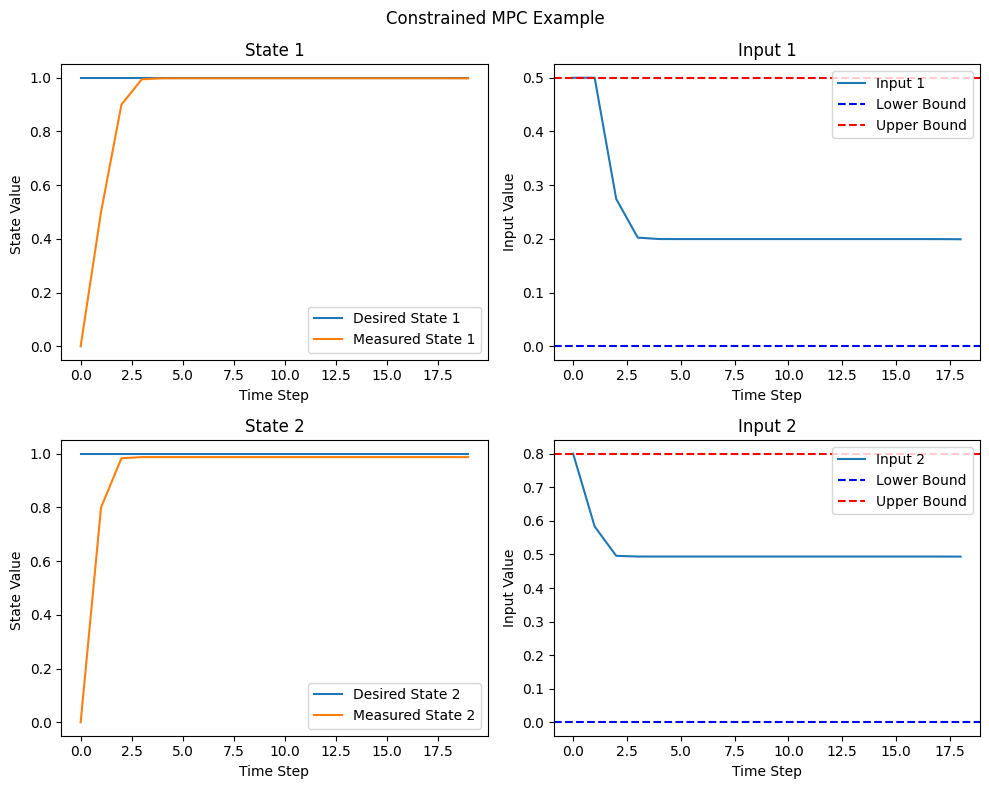

In [14]:
# introduce input constraints
umax = np.array([0.5, 0.8])
umin = np.zeros(2)
mpc2 = MPC(xk=xk, Xd=Xd, N=N, Ak=Ak, Bk=Bk, Q=Q, R=R, umin=umin, umax=umax, measure_runtime=True)

U = mpc2.solve()
X = mpc2.get_predicted_state()
J = mpc2.get_predicted_cost()
runtime_mpc = mpc2.get_runtime()
print(f'Predicted cost: {J}')
print(f'Runtime: {runtime_mpc/1e6:.2f} ms')

plot_mpc('Constrained MPC Example', xk, X, Xd, U, umin, umax)

Higher costs are observed and inputs are limited as expected. Now the MPC update function allowes efficent calculation of only necessary parameters to greatly reduce runtime. In the following example, only the initial state and dynamics are slightly changed, which is a common scenario in practice when the MPC is running in a loop.

Predicted cost: 9.088419758302532
Runtime: 0.74 ms


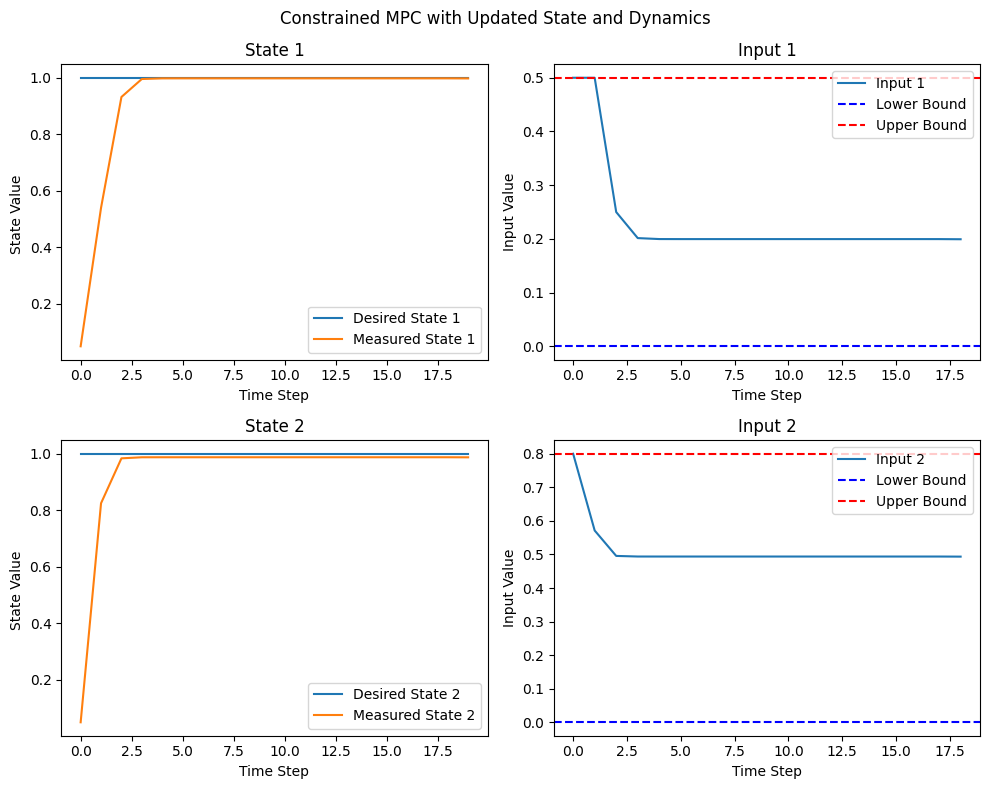

In [15]:
# update initial state and dynamics
xk = np.array([0.05, 0.05])
Ak = np.array([[0.9, 0.0], [0.0, 0.6]])

mpc2.update(xk= xk, Ak= Ak)
U = mpc2.solve()
X = mpc2.get_predicted_state()
J = mpc2.get_predicted_cost()
runtime_mpc = mpc2.get_runtime()
print(f'Predicted cost: {J}')
print(f'Runtime: {runtime_mpc/1e6:.2f} ms')

plot_mpc('Constrained MPC with Updated State and Dynamics', xk, X, Xd, U, umin, umax)

Similarly, the MPC class is utilized in the controller with the distiction that time varying dynamics are used and the above mentioned quadruped constraint matrices are calculated and given by the higher level controller.

## 4. Control Strategy

Our control strategy employs two distinct controllers: one for legs in swing phase and another for legs in stance phase. Each controller is tailored to the specific task at hand, ensuring precise coordination between the legs.

### Stance Leg Control

For legs in stance phase, we apply the forces computed by the Model Predictive Controller (MPC). These forces are projected into the joint space using the translational Jacobian of the foot to generate the corresponding generalized joint torques. This projection is given by:

$$
\tau = J^T F
$$

where $ J $ is the Jacobian matrix, $ F $ represents the force vectors, and $ \tau $ denotes the resulting joint torques.

### Swing Leg Control

For legs in swing phase, a feedback linearization controller is employed to track the desired swing trajectory. The control law is defined as:

$$
\nu = J^{-1} \left( a_d + K_D (v_d - v) + K_P (x_d - x) - \dot{J} \dot{q} \right)
$$

Here, $ \nu $ represents the control input, $ a_d $ is the desired acceleration, $ v_d $ and $ v $ are the desired and actual velocities, and $ x_d $ and $ x $ are the desired and actual positions, respectively. $ K_D $ and $ K_P $ are the damping and stiffness gains, while $ \dot{J} \dot{q} $ accounts for the changing Jacobian with respect to time.

The generalized joint torques $ \tau $ are computed as:

$$
\tau = M(q) \nu + h(q, \dot{q})
$$

where $ M(q) $ is the mass matrix, and $ h(q, \dot{q}) $ accounts for the Coriolis and gravitational forces.

### Controller Decoupling

To ensure that each controller operates independently, a masking technique is employed using the stance phase indicator. This allows for selectively zeroing out control values when necessary, preventing any interference between the swing and stance phase controllers.


## 5. Simulation and Results

To assess the performance of the planner and control strategies, we conducted a full dynamic simulation of the robot, integrating all components of the system. This includes the global and local planners as well as the stance and swing leg controllers

The simulation provides a comprehensive evaluation of the robot’s motion, allowing us to verify the effectiveness of the trajectory generation, control laws, and overall system coordination. 

The following sections provide detailed analyses of the simulation results, showcasing the robot's response to different velocity inputs and gait configurations.


In [19]:
from project_code.controller import leg_controller

#planner = Planner(CRAWL, 0.7, 0.25, 0.0, 0.125)
planner = Planner(WALKING_TROT, 0.5, 0.5, 0.0, 0.25)

In [22]:
mujoco.mj_resetDataKeyframe(model, data, 0)
mujoco.mj_forward(model, data)
model.opt.timestep = 0.01

pos_ds = []
pos_ms = []

vel_ds = []
vel_ms = []

frames = []

camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 2
camera.azimuth = 90  # Angle around the Z-axis, adjust as needed
  
for i in range(700):
    if i % 1 == 0: planner.update_planner(state=state)
    pos_d, vel_d, _ = planner.evaluate_trajectory(state.time())

    pos_ds.append(pos_d)
    pos_ms.append(state.get_xpos())
    
    vel_ds.append(vel_d)
    vel_ms.append(state.get_xvel())

    tau = leg_controller(state, *planner.get_control_inputs(state.time()))
    state.get_data().ctrl = tau
    
    mujoco.mj_step(model, state.get_data())
    
    camera.lookat = state.get_data().body('base').subtree_com
    renderer.update_scene(data, camera)
    pixels = renderer.render()
    frames.append(pixels)
    
media.show_video(frames, fps=1 / (model.opt.timestep))

We also evaluate the controller's ability to accurately track the planned trajectories, assessing how effectively the robot's motion adheres to the desired path during both the swing and stance phases.

In [ ]:
from project_code.utils import plot_desired_vs_measured

plot_desired_vs_measured(pos_ds, pos_ms, vel_ds, vel_ms)

### Areas for Improvement

While the current implementation provides satisfactory results in many cases, several areas require further refinement for enhanced performance:

- **Center of Mass (CoM) Estimation:** The estimation of the robot's CoM could be improved, particularly for executing Sinlge Rigid Body Dynamics (SRBD) more accurately. Enhancing this estimation would lead to more precise motion control and stability during dynamic movements. This would hopefully allow us, to reduce the update frequency of the MPC planner.
  
- **Handling Multiple Turns:** The robot encounters challenges when performing multiple consecutive turns around its own axis. 

- **Body Orientation Tracking:** The current controller exhibits some discrepancies in maintaining the desired body orientation. Improved orientation tracking is essential to ensure the robot follows the planned trajectory more accurately, particularly during complex maneuvers.

- **Whole Body Impulse Dynamics (WBID) Implementation:** Future work could include the implementation of Whole Body Impulse Dynamics to compare performance and robustness against the current control strategies. This would enable better handling of high-impact events, such as foot impacts during locomotion.


# 6. References

[1] https://github.com/qpsolvers/qpbenchmark